In [1]:
# general
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from datetime import datetime

import GPUtil

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import torch.nn as nn
import torchvision.models as models
from pytorch_pretrained_bert import BertModel
from transformers import DistilBertModel
import torch.nn.functional as F

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
# Reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

### Structure
- plot images
- text preprocessing
- data loader
- image augmentation

### Text Preprocessing

Bert requires: <br>
- tokenization
- special characters
- padding
- mask

techniques to try (for other models): <br>
- Lower casing
- Punctuation removal
- Stopwords removal
- Frequent words removal
- Rare words removal
- Spelling correction
- Tokenization
- Stemming
- Lemmatization
- word embedding/ bag of words

In [3]:
df = pd.read_pickle('../data/labeled_data.p')

# analyze imbalance
print(df["class"].value_counts())

# drop class 1 for the first
#df = df.drop(df[df['class'] == 1].index)
df = df.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

# convert class 2 -> 1 to be in accordance with standards
'''
def convert_standard(x):
    return 0 if x == 0 else 1
df['class'] = df['class'].apply(convert_standard) 
'''

df0 = df.loc[df['class']==0]
df1 = df.loc[df['class']==1]
df2 = df.loc[df['class']==2]
df = pd.concat([df0[:1400], df1[:4000], df2[:4000]])

print(df["class"].value_counts())

print(df.head(10))


1    19190
2     4163
0     1430
Name: class, dtype: int64
2    4000
1    4000
0    1400
Name: class, dtype: int64
    class                                              tweet
85      0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...
90      0  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...
111     0  "@DevilGrimz: @VigxRArts you're fucking gay, b...
186     0  "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...
204     0  "@NoChillPaz: "At least I'm not a nigger" http...
206     0  "@NotoriousBM95: @_WhitePonyJr_ Ariza is a sna...
221     0  "@RTNBA: Drakes new shoes that will be release...
263     0  "@TheoMaxximus: #GerrysHalloweenParty http://t...
317     0  "@ashlingwilde: @ItsNotAdam is bored supposed ...
320     0  "@bigbootybishopp: @white_thunduh lassen cc , ...


In [4]:
import re
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

df['tweet'] = df['tweet'].apply(preprocess)
df = df[df["tweet"]!='']

print(df.head())


    class                                              tweet
85      0                                       queer gaywad
90      0  alsarabsss hes a beaner smh you can tell hes a...
111     0  youre fucking gay blacklisted hoe holding out ...
186     0                       lmfaoooo i hate black people
204     0                     at least im not a nigger lmfao


In [5]:
#dataset_df = pd.read_json('../data/train.jsonl', lines=True)

# dictionary
data = df.to_dict(orient='records') # have been shuffled in previous step

print(df)

# train valid split
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(data, test_size=0.20)
#valid_data, _ = train_test_split(valid_data, test_size=0.9)


wc = df['class'].value_counts()
print(wc)
wc = 1/wc/ sum(1/wc)
weight_classes = torch.tensor(wc)
print(weight_classes)

      class                                              tweet
85        0                                       queer gaywad
90        0  alsarabsss hes a beaner smh you can tell hes a...
111       0  youre fucking gay blacklisted hoe holding out ...
186       0                       lmfaoooo i hate black people
204       0                     at least im not a nigger lmfao
...     ...                                                ...
24207     2  cheeky lol rt i want those all black and yello...
24208     2                            chicken spaghetti trash
24214     2  cleaned all the bird nests out of the downspou...
24215     2                        colored denim makes me puke
24216     2  cookies and crackers arent even on the same le...

[9389 rows x 2 columns]
1    3997
2    3993
0    1399
Name: class, dtype: int64
tensor([0.2058, 0.2061, 0.5881], dtype=torch.float64)


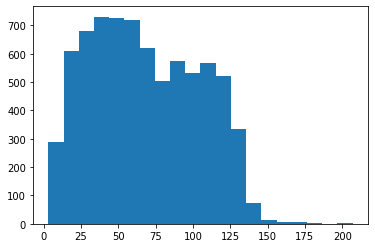

In [6]:
# split into text (input) and labels (output)
train_texts, train_labels = list(zip(*map(lambda d: (d['tweet'], d['class']), train_data)))
valid_texts, valid_labels = list(zip(*map(lambda d: (d['tweet'], d['class']), valid_data)))

len(train_texts), len(train_labels), len(valid_texts), len(valid_labels)

train_texts_len = list(map(lambda t: len(t), train_texts))

plt.figure()
plt.hist(train_texts_len, bins=20)
plt.show()

In [7]:
# class imbalance
print(sum(train_labels)/ len(train_labels))
print(sum(valid_labels)/ len(valid_labels))

1.2749301025163093
1.2816826411075612


In [8]:
# bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [9]:
# token embeddings with required separation token
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:124] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:124] + ['[SEP]'], valid_texts))

len(train_tokens), len(valid_tokens)

(7511, 1878)

In [10]:
# put everything back into a dictionary
data_train = {'tokens': train_tokens, 'labels': train_labels}

data_valid = {'tokens': valid_tokens, 'labels': valid_labels}

## Dataloader

In [11]:
pretrained_dict = pretrained_model.state_dict()class HatefulMemesDataset(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data):
        """
        Args:
            df_path (string): path to jsonl file with image id's
            root_dir (string): directory with all the images
            transform (callable): optional transform to be applied on a sample
        """
        # text
        self.data = data

    def __len__(self):
        return len(self.data['labels'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
            
            
        data_train = {'tokens': train_tokens, 'labels': train_labels}
        
        # label ------------------------------------------
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # token -------------------------------------------
        token = self.data['tokens'][idx]

        # prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
        # further need to make all review the same length -> padding too short, truncating too long ones
        token_id = pad_sequences([tokenizer.convert_tokens_to_ids(token)], maxlen=126, truncating="post", padding="post", dtype="int")
        token_id = token_id.reshape(-1)
        
        # mask for padding -> required by bert
        mask = [float(i > 0) for i in token_id]
        mask = np.array([mask])
        mask = mask.astype('float').reshape(-1)
        
        #
        sample = {'token_id': token_id, 'mask': mask, 'label': label}
            
        return sample

## Model 

In [12]:
# https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/2
class MyEnsemble(nn.Module):
    def __init__(self):
        super(MyEnsemble, self).__init__()
        # pretrained models
        self.modelNLP = BertModel.from_pretrained('bert-base-cased')
        
        # classifier layer
        #self.layernorm1 = torch.nn.LayerNorm(768)
        self.classifier1 = nn.Linear(768, 3)
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, tokens, masks):
        # Bert is such that the first token contains all info for classification
        _, x2 = self.modelNLP(tokens, attention_mask=masks, output_all_encoded_layers=False)
        #x = self.layernorm1(x2)
        x = self.dropout(x2)
        y = self.classifier1(x)
        
        return y

In [13]:
model = MyEnsemble()

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

modelNLP.embeddings.word_embeddings.weight
modelNLP.embeddings.position_embeddings.weight
modelNLP.embeddings.token_type_embeddings.weight
modelNLP.embeddings.LayerNorm.weight
modelNLP.embeddings.LayerNorm.bias
modelNLP.encoder.layer.0.attention.self.query.weight
modelNLP.encoder.layer.0.attention.self.query.bias
modelNLP.encoder.layer.0.attention.self.key.weight
modelNLP.encoder.layer.0.attention.self.key.bias
modelNLP.encoder.layer.0.attention.self.value.weight
modelNLP.encoder.layer.0.attention.self.value.bias
modelNLP.encoder.layer.0.attention.output.dense.weight
modelNLP.encoder.layer.0.attention.output.dense.bias
modelNLP.encoder.layer.0.attention.output.LayerNorm.weight
modelNLP.encoder.layer.0.attention.output.LayerNorm.bias
modelNLP.encoder.layer.0.intermediate.dense.weight
modelNLP.encoder.layer.0.intermediate.dense.bias
modelNLP.encoder.layer.0.output.dense.weight
modelNLP.encoder.layer.0.output.dense.bias
modelNLP.encoder.layer.0.output.LayerNorm.weight
modelNLP.encoder.lay

In [15]:
'''
# Initialize model
model.apply(weight_init)
model_dict = model.state_dict()

# Fiter out unneccessary keys
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)
'''

'\n# Initialize model\nmodel.apply(weight_init)\nmodel_dict = model.state_dict()\n\n# Fiter out unneccessary keys\nfiltered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}\nmodel_dict.update(filtered_dict)\nmodel.load_state_dict(model_dict)\n'

In [16]:
# allocate on gpu
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

model = MyEnsemble().to(device)
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

GPUtil.showUtilization()

print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

433.781248M
| ID | GPU | MEM |
------------------
|  0 |  8% | 23% |
108314115
108314115


In [17]:
from torch.optim import Adam
# TODO: not sure if this does what I think it should do
# optimizer
lr = 5e-6
optimizer = Adam(model.parameters(), lr=lr) # TODO: SGD for just the final classifier

In [18]:
def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:        
        # TODO: should work since target = {0, 1}, thus sets weights to zero if not needed
        loss = weights * (target * torch.log(output)) + \
               weights * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [19]:
from datetime import date
# summary writer
log_dir = './summaries/summary'+ date.today().strftime('%H-%d-%m-%Y')
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir)

## Training

In [20]:
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import roc_auc_score

# training
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

EPOCHS = 5
BATCH_SIZE_TRAIN = 8 # 4 if grad for all paramters
BATCH_SIZE_VALID = 4

# weight correction TODO
weight_correction = sum(wc)* (1/wc[0]+ 1/wc[1]+ 1/wc[2]) / 3

# training
train_dataset = HatefulMemesDataset(data_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, num_workers=1, shuffle=True)

# validation
valid_dataset = HatefulMemesDataset(data_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_VALID, shuffle=False)

# loss fcn
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum', weight=weight_classes.float().to(device))

# monitor train progress
stats = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': [], 'val_rocauc': []}

time_tot = []

for epoch_num in range(EPOCHS):
    #
    train_loss = 0.
    train_correct = 0.
    
    valid_loss = 0.
    valid_correct = 0.
    
    # training ---------------------------------------------------
    model.train()
        
    for step_num, batch in enumerate(train_loader):
        
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}                
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)
        # imgs, token_ids, masks, labels = tuple(t.to(device) for t in batch)
        # print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        
        logits = model(token_ids, masks)
        preds = torch.reshape(torch.argmax(logits, dim=1), [-1,1])
        
        # account for class imbalance
        eye = torch.ones(labels.shape, device=device)
        weight_imbalance = (labels==0*eye).int()* wc[0] + (labels==eye).int()* wc[1]+ (labels==2*eye).int()* wc[2]
   
        # loss
        batch_loss = loss_fn(logits, labels.squeeze())
        train_loss += batch_loss.item()
        train_correct += sum((preds==labels)* weight_imbalance).item()* weight_correction # adjust accuracy to [0,1]
        
        
        '''
        batch_loss = weighted_binary_cross_entropy(logits, labels.float())
        train_loss += batch_loss.item()
        train_correct += sum((torch.round(logits)==labels)).item()
        '''
        
        # reset gradient and calculate new ones
        model.zero_grad()
        batch_loss.backward()
        
        # gradient clipping and backward pass
        #clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        # logging
        # clear_output(wait=True) -> from IPython.display import clear_output
        if step_num%50==0 and step_num> 0:
            print('Epoch: ', epoch_num + 1)
            print("\r" + "{0}/{1} loss: {2} acc: {3} ".format(step_num,
                                                              len(train_data) / BATCH_SIZE_TRAIN,
                                                              round(train_loss / (step_num + 1), 3),
                                                              round(train_correct/ ((step_num+1)* BATCH_SIZE_TRAIN), 3)))
    
    # train stats
    stats['train_loss'].append(train_loss / ((step_num+1)* BATCH_SIZE_TRAIN))
    stats['train_acc'].append(train_correct / ((step_num+1)* BATCH_SIZE_TRAIN))
    
    writer.add_scalar('Loss/train', train_loss / ((step_num+1)* BATCH_SIZE_TRAIN), epoch_num)
    writer.add_scalar('Accuracy/train', train_correct / ((step_num+1)* BATCH_SIZE_TRAIN), epoch_num)
    
    # validation ---------------------------------------
    # TODO to calculate metrics
    ypred = []
    ytrue = []
    weight = []

    for step_num, batch in enumerate(valid_loader):
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)

        # account for class imbalance (66% label 0, 33% label 1)
        eye = torch.ones(labels.shape, device=device)
        weight_imbalance = (labels==0*eye).int()* wc[0] + (labels==eye).int()* wc[1]+ (labels==2*eye).int()* wc[2]
        
        # loss
        logits = model(token_ids, masks)
        preds = torch.reshape(torch.argmax(logits, dim=1), [-1,1])
        
        batch_loss = loss_fn(logits, labels.squeeze())
        valid_loss += batch_loss.item()
        valid_correct += sum((preds==labels)* weight_imbalance).item()* weight_correction # adjust accuracy to [0,1]

        '''
        batch_loss = weighted_binary_cross_entropy(logits, labels.float())
        valid_loss += batch_loss.item()
        
        valid_correct += sum((torch.round(logits)==labels)).item()
        '''

    # valid stats
    stats['valid_loss'].append(valid_loss / ((step_num+1)* BATCH_SIZE_VALID))
    stats['valid_acc'].append(valid_correct / ((step_num+1)* BATCH_SIZE_VALID))
    
    writer.add_scalar('Loss/valid', valid_loss / ((step_num+1)* BATCH_SIZE_VALID), epoch_num)
    writer.add_scalar('Accuracy/valid', valid_correct / ((step_num+1)* BATCH_SIZE_VALID), epoch_num)

    # optimizer lr decay: domain specific pre-training -> lr=2e-5
    #lr*= 0.9
    #optimizer = Adam(model.parameters(), lr=lr)

torch.save(model.state_dict(), '../models/'+ datetime.now().strftime('%H-%d-%m-%Y'))
writer.close()

Epoch:  1
50/938.875 loss: 2.774 acc: 0.322 
Epoch:  1
100/938.875 loss: 2.691 acc: 0.326 
Epoch:  1
150/938.875 loss: 2.598 acc: 0.337 
Epoch:  1
200/938.875 loss: 2.519 acc: 0.343 
Epoch:  1
250/938.875 loss: 2.467 acc: 0.349 
Epoch:  1
300/938.875 loss: 2.368 acc: 0.366 
Epoch:  1
350/938.875 loss: 2.277 acc: 0.381 
Epoch:  1
400/938.875 loss: 2.191 acc: 0.397 
Epoch:  1
450/938.875 loss: 2.115 acc: 0.416 
Epoch:  1
500/938.875 loss: 2.04 acc: 0.435 
Epoch:  1
550/938.875 loss: 1.968 acc: 0.452 
Epoch:  1
600/938.875 loss: 1.903 acc: 0.466 
Epoch:  1
650/938.875 loss: 1.858 acc: 0.477 
Epoch:  1
700/938.875 loss: 1.812 acc: 0.487 
Epoch:  1
750/938.875 loss: 1.764 acc: 0.497 
Epoch:  1
800/938.875 loss: 1.721 acc: 0.506 
Epoch:  1
850/938.875 loss: 1.688 acc: 0.513 
Epoch:  1
900/938.875 loss: 1.647 acc: 0.522 
Epoch:  2
50/938.875 loss: 0.885 acc: 0.755 
Epoch:  2
100/938.875 loss: 0.918 acc: 0.74 
Epoch:  2
150/938.875 loss: 0.907 acc: 0.741 
Epoch:  2
200/938.875 loss: 0.865 acc:

NameError: name 'datetime' is not defined

In [22]:
from datetime import datetime
torch.save(model.state_dict(), '../models/'+ datetime.now().strftime('%H-%d-%m-%Y'))
writer.close()

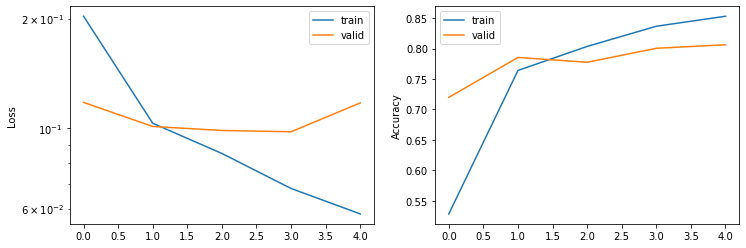

In [23]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].plot(stats['train_loss'])
ax[0].plot(stats['valid_loss'])
ax[0].legend(['train', 'valid'])
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')

ax[1].plot(stats['train_acc'])
ax[1].plot(stats['valid_acc'])
ax[1].legend(['train', 'valid'])
ax[1].set_ylabel('Accuracy')

plt.savefig('../twitter_pretraining_lr5e-6_dropout051.png')
plt.show()